In [32]:
!activate PythonGPU
import numpy as np
from scipy.stats import skewnorm, skew
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, accuracy_score

def simulate_data(classes, n_vars, n, max_mu, max_sigma, max_skew):
    #The multivariate skew normal number generator
    def rng(mu, sigma, skew, n=1):
        k = len(mu)
        if not (k == len(sigma) and k ==len(skew)): 
            raise Exception("Mu, Sigma and Skew should be same length")

        data = np.zeros((int(n),k))

        for i in range(k):
            data[:,i] = skewnorm.rvs(skew[i], loc=mu[i], scale=sigma[i], size=int(n)) 

        return data
    
    if(np.sum(classes) != 1):
        raise Exception("Classes dont sum up to 1")
        
    n_classes = len(classes)
    sigma = np.random.randint(1,max_sigma,n_vars)
    skew = np.random.randint(-max_skew,max_skew,n_vars)
    mu =  np.random.randint(-max_mu, max_mu, (n_classes, n_vars))
    
    n_obs_class = np.round(np.dot(classes,n))
    
    data = np.zeros((int(np.sum(n_obs_class)),n_vars+1))
    for i in range(n_classes):
        #calculate indexes
        start = int(np.sum(n_obs_class[0:i]))
        end = int(np.sum(n_obs_class[0:i+1]))
        
        #set the data
        data[start:end,0] = i
        data[start:end,1:] = rng(mu[i,:], sigma, skew, n_obs_class[i])
        
    X = data[:,1:]
    y = data[:,0]
    
    columns = ["x"+str(x) for x in range(n_vars + 1)]
    columns[0] = "class"
    
    df = pd.DataFrame(data,columns=columns)
    df["class"] = df["class"].astype(int)
    return X,y, df



#parameters
classes = [0.25, 0.25, 0.25, 0.25] #percentages
n_vars = 2
n = 100000
max_mu = 4
max_sigma = 30
max_skew = 10
np.random.seed(12345)

#generate data
X,y, df = simulate_data(classes, n_vars, n, max_mu, max_sigma, max_skew)

display(df.groupby(["class"]).agg(["count", "mean", "var"]))

#make train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.33, 
    random_state=42,
    stratify=y)


accuracies = pd.DataFrame(columns=['method', 'accuracy', 'predictions'])

x1                         x2                     
       count      mean       var  count      mean        var
class                                                       
0      25000 -5.418810  3.404696  25000 -2.785668  14.072727
1      25000 -0.382507  3.372791  25000 -3.719970  13.815809
2      25000 -4.357486  3.331428  25000 -3.711755  13.493996
3      25000 -5.376596  3.282862  25000 -2.701396  13.696829

LDA Test accuracy 0.5007272727272727
              precision    recall  f1-score   support

         0.0       0.38      0.32      0.35      8250
         1.0       0.89      0.86      0.87      8250
         2.0       0.37      0.56      0.44      8250
         3.0       0.39      0.28      0.32      8250

   micro avg       0.50      0.50      0.50     33000
   macro avg       0.51      0.50      0.50     33000
weighted avg       0.51      0.50      0.50     33000



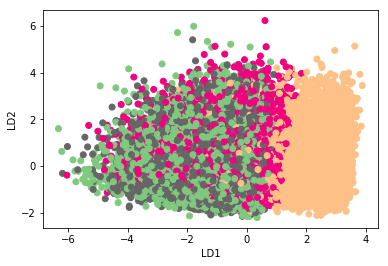

In [33]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(priors=classes)
X_lda = lda.fit_transform(X_train, y_train)



lda_pred = lda.predict(X_test)
lda_acc = accuracy_score(y_test, lda_pred)
print("LDA Test accuracy "+ str(lda_acc))
# confusion_matrix(y_test, lda_pred)
print(classification_report(y_test, lda_pred))

accuracies = accuracies.append({"method": "LDA", 
                   "accuracy":lda_acc, 
                   "predictions":lda_pred}, 
                    ignore_index=True)



plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y_train,
    cmap='Accent',
#      alpha=0.7,
#      edgecolors='grey'
)

In [34]:
#Quadratic
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis(priors=classes)
X_qda = qda.fit(X_train, y_train)



qda_pred = qda.predict(X_test)
qda_acc = accuracy_score(y_test, qda_pred)
print("QDA Test accuracy "+ str(qda_acc))
# confusion_matrix(y_test, lda_pred)
print(classification_report(y_test, qda_pred))

accuracies = accuracies.append({"method": "QDA", 
                   "accuracy":qda_acc, 
                   "predictions":qda_pred}, 
                    ignore_index=True)

QDA Test accuracy 0.5025151515151515
              precision    recall  f1-score   support

         0.0       0.40      0.21      0.28      8250
         1.0       0.89      0.86      0.87      8250
         2.0       0.37      0.55      0.44      8250
         3.0       0.38      0.39      0.39      8250

   micro avg       0.50      0.50      0.50     33000
   macro avg       0.51      0.50      0.49     33000
weighted avg       0.51      0.50      0.49     33000



In [35]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train, y_train)


clf_pred = clf.predict(X_test)
clf_acc = accuracy_score(y_test, clf_pred)
print("Logistic Test accuracy "+ str(clf_acc))

accuracies = accuracies.append({"method": "Logit", 
                   "accuracy":clf_acc, 
                   "predictions":clf_pred}, 
                    ignore_index=True)

# confusion_matrix(y_test, lda_pred)
print(classification_report(y_test, clf_pred))

# plt.xlabel('LD1')
# plt.ylabel('LD2')
# plt.scatter(
#     clf[:,0],
#     clf[:,1],
#     c=y_train,
#     cmap='Accent',
# #      alpha=0.7,
# #      edgecolors='grey'
# )

Logistic Test accuracy 0.49542424242424243
              precision    recall  f1-score   support

         0.0       0.38      0.30      0.34      8250
         1.0       0.86      0.87      0.86      8250
         2.0       0.36      0.52      0.43      8250
         3.0       0.39      0.29      0.33      8250

   micro avg       0.50      0.50      0.50     33000
   macro avg       0.50      0.50      0.49     33000
weighted avg       0.50      0.50      0.49     33000



In [ ]:
#KNN

In [ ]:
#Naive bayes

In [ ]:
#SVM

In [36]:
from tensorflow.keras import layers
from tensorflow import keras

inputs = keras.Input(shape=(n_vars,), name='obs')
x = layers.Dense(40, activation='relu')(inputs)
x = layers.Dense(40, activation='relu')(x)
x = layers.Dense(40, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Dataset')

display(model.summary())


model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=20,
                    validation_split=0.2)

test_scores = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

accuracies = accuracies.append({"method": "Neural Net", 
                   "accuracy": test_scores[1], 
                   "predictions":clf_pred}, 
                    ignore_index=True)

Model: "Dataset"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
obs (InputLayer)             [(None, 2)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 40)                120       
_________________________________________________________________
dense_13 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_14 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                410       
Total params: 3,810
Trainable params: 3,810
Non-trainable params: 0
_________________________________________________________________


None

Train on 53600 samples, validate on 13400 samples
Epoch 1/20
53600/53600 [==============================] - 5s 86us/sample - loss: 1.0121 - accuracy: 0.4938 - val_loss: 0.9416 - val_accuracy: 0.5107
Epoch 2/20
53600/53600 [==============================] - 4s 70us/sample - loss: 0.9350 - accuracy: 0.5076 - val_loss: 0.9275 - val_accuracy: 0.5122
Epoch 3/20
53600/53600 [==============================] - 4s 70us/sample - loss: 0.9303 - accuracy: 0.5105 - val_loss: 0.9261 - val_accuracy: 0.5159
Epoch 4/20
53600/53600 [==============================] - 4s 71us/sample - loss: 0.9288 - accuracy: 0.5107 - val_loss: 0.9264 - val_accuracy: 0.5116
Epoch 5/20
53600/53600 [==============================] - 4s 72us/sample - loss: 0.9280 - accuracy: 0.5122 - val_loss: 0.9234 - val_accuracy: 0.5115
Epoch 6/20
53600/53600 [==============================] - 4s 74us/sample - loss: 0.9274 - accuracy: 0.5130 - val_loss: 0.9248 - val_accuracy: 0.5172
Epoch 7/20
53600/53600 [==============================] 

In [37]:
accuracies

,method,accuracy,predictions
0,LDA,0.500727,"[3.0, 2.0, 0.0, 3.0, 1.0, 2.0, 3.0, 2.0, 2.0, ..."
1,QDA,0.502515,"[3.0, 2.0, 0.0, 3.0, 1.0, 2.0, 3.0, 2.0, 2.0, ..."
2,Logit,0.495424,"[3.0, 2.0, 0.0, 3.0, 1.0, 2.0, 3.0, 1.0, 2.0, ..."
3,Neural Net,0.515030,"[3.0, 2.0, 0.0, 3.0, 1.0, 2.0, 3.0, 1.0, 2.0, ..."
